In [2]:
%pip install pandas matplotlib scipy seaborn xelatex

ERROR: Could not find a version that satisfies the requirement xelatex (from versions: none)
ERROR: No matching distribution found for xelatex
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import glob
from scipy import stats
from scipy.signal import savgol_filter
from dateutil import tz

In [4]:
from common import combine_csvs
from common import region_mapping
import common

In [5]:
N_REGIONS = 'Regions'
N_TIMESTAMP = 'Timestamp'
N_TYPE = 'Type'
N_LATENCY = 'Latency (ms)'

N_STARLINK = 'Starlink'
N_STARLINK_REMOTE = 'Starlink Remote'
N_HOME = 'Home'

REGION_ORDER = ['N. California', 'Tokyo', 'London', 'Sydney', 'Singapore',
            'Sao Paulo', 'Bahrain', 'Mumbai', 'Cape Town']

#src_dirs = ['data/trad_ping_2022-04-14', 'data/starlink_ping_2022-04-14/']
#src_dirs = ['data/Home_network_data/Ping/2022-06-06_traditional_measures_ping/', 'data/starlink-data/Ping/2022-06-06_starlink_ping/']
#src_dirs = [
#    ('Home', 'data/Home_network_data/Ping/2022-06-03_traditional_measures_ping/'), 
#    ('Starlink', 'data/starlink-data/Ping/2022-06-03_starlink_measurements_ping/'),
#    ('Home', 'data/Home_network_data/Ping/2022-06-06_traditional_measures_ping/'),
#    ('Starlink', 'data/starlink-data/Ping/2022-06-06_starlink_ping/'),
#]

OUT_PATH = 'output/Ping'
filename = os.path.join(OUT_PATH, 'out_plot')

In [6]:
src_dirs = []
for folder in glob.glob('data/starlink-data/Ping/*'):
    if os.path.isdir(folder):
        src_dirs.append(('Starlink', folder))
for folder in glob.glob('data/Home_network_data/Ping/*'):
    if os.path.isdir(folder):
        src_dirs.append(('Home', folder))
        
src_dirs = [(N_STARLINK_REMOTE, 'data/Koeye/koeye_ping_measurements_2022-05-20/')]
src_dirs

[('Starlink Remote', 'data/Koeye/koeye_ping_measurements_2022-05-20/')]

In [7]:
plot_params = common.plot_params
plot_params['figure.figsize'] = (7.16, 4)
plot_params['figure.dpi'] = 300
#matplotlib.rcParams.update(plot_params)

sns_params = common.sns_params
sns_params['figure.figsize'] = (7.16, 4)
sns_params['figure.dpi'] = 300
#sns_params['patch.edgecolor'] = 'black'
sns.set_theme("paper", style='whitegrid', rc=sns_params, color_codes=True, palette='bright')
#sns.set_context("paper", rc=sns_params)
#sns.set(rc=sns_params)

In [8]:
df_old = pd.read_csv(os.path.join(OUT_PATH, '2022-06-17_end_all_ping_data.csv'), index_col=False)
df_old[N_TIMESTAMP] = pd.to_datetime(df_old[N_TIMESTAMP])
df_old

,Latency (ms),Timestamp,Regions,Type,Outliers
0,57.4,2022-04-13 05:06:07,N. California,Starlink,False
1,47.8,2022-04-13 05:06:08,N. California,Starlink,False
2,61.9,2022-04-13 05:06:09,N. California,Starlink,False
3,52.9,2022-04-13 05:06:10,N. California,Starlink,False
4,51.0,2022-04-13 05:06:11,N. California,Starlink,False
...,...,...,...,...,...
54583138,289.0,2022-06-17 08:39:47,Cape Town,Home,False
54583139,145.0,2022-06-17 08:39:47,London,Home,False
54583140,261.0,2022-06-17 08:39:47,Mumbai,Home,False
54583141,156.0,2022-06-17 08:39:47,Sydney,Home,False


In [9]:
df = pd.DataFrame()
for type_name, folder in src_dirs:
    for region in glob.glob(f'{folder}/*'):
        pattern = f"{region}/*"
        print(pattern)
        #print(pattern)
        df_temp = combine_csvs(glob.glob(pattern, recursive=True), None, header=None)
        df_temp = df_temp.iloc[:,[2, 3]]
        df_temp.rename(columns={df_temp.columns[0]: N_LATENCY, df_temp.columns[1]: N_TIMESTAMP}, inplace=True)
        df_temp[N_TIMESTAMP] = pd.to_datetime(df_temp[N_TIMESTAMP], unit='s')
        df_temp.sort_values(N_TIMESTAMP, inplace=True)
        df_temp[N_REGIONS] = region_mapping[os.path.basename(region)]
        df_temp[N_TYPE] = type_name

        if not df.empty:
            #df = df.merge(df_temp, how='outer', left_index=True, right_index=True)
            #df = df.update(df_temp, errors='raise')
            df = pd.concat([df, df_temp])
        else:
            df = df_temp
            
df = df.reset_index(drop=True)
df

data/Koeye/koeye_ping_measurements_2022-05-20/South_America_Sao_Paulo/*
data/Koeye/koeye_ping_measurements_2022-05-20/Asia_Pacific_Singapore/*
data/Koeye/koeye_ping_measurements_2022-05-20/Asia_Pacific_Sydney/*
data/Koeye/koeye_ping_measurements_2022-05-20/Africa_Cape_Town/*
data/Koeye/koeye_ping_measurements_2022-05-20/US_West_N_California/*
data/Koeye/koeye_ping_measurements_2022-05-20/Middle_East_Bahrain/*
data/Koeye/koeye_ping_measurements_2022-05-20/Asia_Pacific_Tokyo/*
data/Koeye/koeye_ping_measurements_2022-05-20/Europe_London/*
data/Koeye/koeye_ping_measurements_2022-05-20/Asia_Pacific_Mumbai/*


,Latency (ms),Timestamp,Regions,Type
0,240.0,2022-05-21 04:41:45,Sao Paulo,Starlink Remote
1,234.0,2022-05-21 04:41:46,Sao Paulo,Starlink Remote
2,244.0,2022-05-21 04:41:47,Sao Paulo,Starlink Remote
3,294.0,2022-05-21 04:41:48,Sao Paulo,Starlink Remote
4,226.0,2022-05-21 04:41:49,Sao Paulo,Starlink Remote
...,...,...,...,...
1315343,313.0,2022-05-23 15:51:11,Mumbai,Starlink Remote
1315344,311.0,2022-05-23 15:51:13,Mumbai,Starlink Remote
1315345,293.0,2022-05-23 15:51:14,Mumbai,Starlink Remote
1315346,306.0,2022-05-23 15:51:15,Mumbai,Starlink Remote


In [10]:
#df_temp = combine_csvs(glob.glob(f'{src_dirs[1]}/US_West_N_California/*', recursive=True), 3, header=None)
#df_temp.index = pd.to_datetime(df_temp.index, unit='s')
#df_temp.sort_index()
#df.loc['2022-06-17 01']

In [11]:
# https://stackoverflow.com/questions/69300483/how-to-use-markers-with-ecdf-plot
def ecdf(data, array: bool=True):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    if not array:
        return pd.DataFrame({'x': x, 'y': y})
    else:
        return x, y

In [12]:
# Discern outliers
N_OUTLIERS = 'Outliers'
df_outliers = df_old.copy()
zscore = np.abs(df_outliers.groupby([
    N_TYPE, N_REGIONS])[N_LATENCY].transform(
    lambda x : stats.zscore(x, ddof=1, nan_policy='omit')
))
df_outliers[N_OUTLIERS] = (np.abs(zscore) >= 3.5)
df_outliers = df_outliers.sort_values(N_LATENCY)
df_outliers

#df_starlink_no_outliers = df_starlink[
#    (np.abs(stats.zscore(df_starlink[N_LATENCY], nan_policy='omit')) < 3.5)
#]
#df_no_outliers = pd.concat([df_starlink_no_outliers, df_home_no_outliers]).reset_index(drop=True)
#df_no_outliers

,Latency (ms),Timestamp,Regions,Type,Outliers
16151839,25.6,2022-06-02 06:54:10,N. California,Home,False
1457351,25.8,2022-04-19 03:54:36,N. California,Home,False
28980302,25.9,2022-06-08 04:50:04,N. California,Home,False
91957,25.9,2022-04-15 04:45:30,N. California,Home,False
53669735,25.9,2022-06-17 00:40:08,N. California,Home,False
...,...,...,...,...,...
5043008,13484.0,2022-05-11 21:06:27,Sao Paulo,Starlink,True
5043009,13524.0,2022-05-11 21:06:27,Sydney,Starlink,True
5043012,13572.0,2022-05-11 21:06:27,Singapore,Starlink,True
562526,13591.0,2022-04-16 13:33:57,Sydney,Starlink,True


In [13]:
df_combined = pd.concat([df_old, df_outliers])
print(df_combined.dtypes)
df_combined

Latency (ms)           float64
Timestamp       datetime64[ns]
Regions                 object
Type                    object
Outliers                  bool
dtype: object


,Latency (ms),Timestamp,Regions,Type,Outliers
0,57.4,2022-04-13 05:06:07,N. California,Starlink,False
1,47.8,2022-04-13 05:06:08,N. California,Starlink,False
2,61.9,2022-04-13 05:06:09,N. California,Starlink,False
3,52.9,2022-04-13 05:06:10,N. California,Starlink,False
4,51.0,2022-04-13 05:06:11,N. California,Starlink,False
...,...,...,...,...,...
5043008,13484.0,2022-05-11 21:06:27,Sao Paulo,Starlink,True
5043009,13524.0,2022-05-11 21:06:27,Sydney,Starlink,True
5043012,13572.0,2022-05-11 21:06:27,Singapore,Starlink,True
562526,13591.0,2022-04-16 13:33:57,Sydney,Starlink,True


In [ ]:
#df_outliers = df_outliers.sort_values(N_TIMESTAMP)
#df_outliers.to_csv(os.path.join(out_path, '2022-06-17_end_all_ping_data.csv'), index=False)
#df_outliers.to_csv(os.path.join(out_path, '2022-06-21_end_koeye_ping_data.csv'), index=False)

In [13]:
# Filter
#df_processed = df_outliers[df_outliers[N_OUTLIERS] == False]
#df_processed = df.loc['2022-05-13 07:13:50':'2022-05-13 7:14:18']
#df_processed = df.loc['2022-06-05':'2022-06-05 01']

df_processed = df_combined.groupby([N_OUTLIERS, N_TYPE, N_REGIONS]).resample('15S', on=N_TIMESTAMP).mean()
df_processed = df_processed.drop(N_OUTLIERS, axis=1).reset_index().dropna()
#df_processed.to_csv('output/out.csv')
df_processed

,Outliers,Type,Regions,Timestamp,Latency (ms)
0,False,Home,Bahrain,2022-05-09 09:56:15,226.125000
1,False,Home,Bahrain,2022-05-09 09:56:30,226.600000
2,False,Home,Bahrain,2022-05-09 09:56:45,227.333333
3,False,Home,Bahrain,2022-05-09 09:57:00,226.533333
4,False,Home,Bahrain,2022-05-09 09:57:15,226.600000
...,...,...,...,...,...
8983494,True,Starlink Remote,Tokyo,2022-05-23 15:29:30,453.000000
8983500,True,Starlink Remote,Tokyo,2022-05-23 15:31:00,594.000000
8983503,True,Starlink Remote,Tokyo,2022-05-23 15:31:45,581.000000
8983537,True,Starlink Remote,Tokyo,2022-05-23 15:40:15,693.000000


In [ ]:
df_regs_interp = df_processed.interpolate(method='linear')
#df_regs_interp = df_regs_interp.apply(lambda x: savgol_filter(x,41,1))
df_regs_interp

In [10]:
df_cdf = df_processed.groupby([N_TYPE, N_REGIONS])[N_LATENCY].apply(ecdf, False)
#df_cdf = df_processed.value_counts().sort_index().cumsum() * 1./len(df_processed)
df_cdf = df_cdf.reset_index().drop('level_2', axis=1)
df_cdf

,Type,Regions,x,y
0,Home,Bahrain,224.735891,0.001873
1,Home,Bahrain,224.801556,0.003745
2,Home,Bahrain,224.915184,0.005618
3,Home,Bahrain,224.921345,0.007491
4,Home,Bahrain,224.950236,0.009363
...,...,...,...,...
10026,Starlink,Tokyo,175.907943,0.993068
10027,Starlink,Tokyo,176.055275,0.994801
10028,Starlink,Tokyo,176.383876,0.996534
10029,Starlink,Tokyo,177.538157,0.998267


In [ ]:
#df_pivot = df_unstacked.pivot_table(index=[N_REGIONS, 'timestamp'], columns='type', values='latency')
#print(df_pivot.head())

g = sns.catplot(data=df_unstacked, x='type', y='latency', col=N_REGIONS, col_wrap=4, kind='box', height=2,
        aspect=0.895, showfliers=True)
g.set(yscale='log')
g.tight_layout()
(g.set_axis_labels('Provider', 'Latency (ms)')
        .set_titles("{col_name}"))

/tmp/ipykernel_1937464/1260913135.py:5: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_time = df_processed.set_index(N_TIMESTAMP)['2022-06-03':].reset_index()


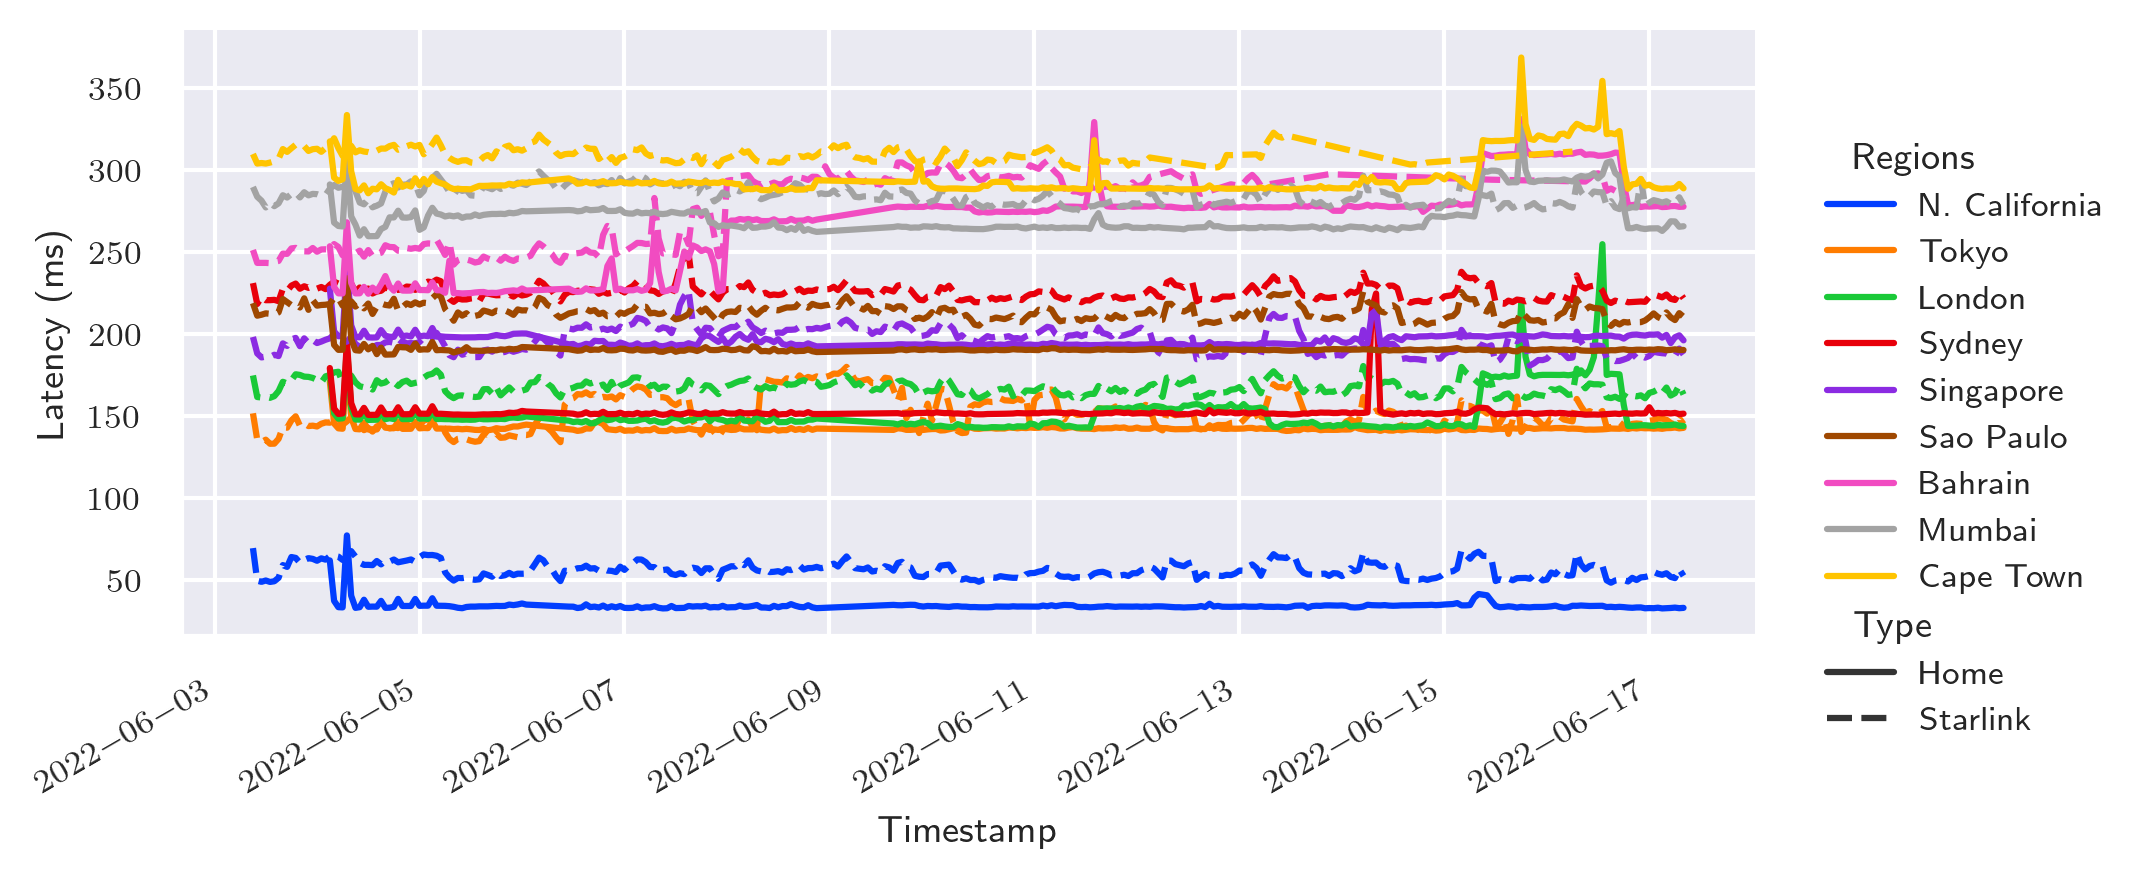

In [138]:
#fig, ax = plt.subplots(figsize=(7.16,4), dpi=100)
#fig, ax = plt.subplots(figsize=(20,10))
# 6.09 for full size, 2.5 for half size

df_time = df_processed.set_index(N_TIMESTAMP)['2022-06-03':].reset_index()

g_time = sns.relplot(data=df_time[df_time[N_OUTLIERS] == False], 
                     x=N_TIMESTAMP, y=N_LATENCY, 
                     hue_order=REGION_ORDER,
                     height=3, aspect=2.03,
                     kind='line',
                     palette='bright',
                     hue=N_REGIONS, style=N_TYPE)
g_time.figure.autofmt_xdate()
ax.set_ylabel('Latency (ms)')
g_time.tight_layout()

In [ ]:
df_sample = df_outliers[df_outliers[N_OUTLIERS] == False]
df_sample = df_sample.pivot_table(
    index=[N_REGIONS,N_TIMESTAMP],
    columns=N_TYPE,
    values=[N_LATENCY, N_OUTLIERS],
    aggfunc={N_LATENCY: np.mean,
             N_OUTLIERS: np.logical_or}
).reset_index()
#df_outliers_type = df_outliers[df_outliers[N_OUTLIERS] == True]
#df_outliers_type = df_outliers_type.pivot_table(index=[N_OUTLIERS, N_REGIONS,N_TIMESTAMP], columns=N_TYPE, values=N_LATENCY).reset_index()

# https://stackoverflow.com/questions/39457762/python-pandas-conditionally-select-a-uniform-sample-from-a-dataframe
df_sample = df_sample.groupby([N_REGIONS]).sample(5000)
#df_sample = pd.concat([df_sample, df_outliers_type]).reset_index(drop=True)
df_sample

/tmp/ipykernel_2595660/222356102.py:2: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  df_sample = df_sample.pivot_table(


In [64]:
t = df_sample.dropna()
#t[t[N_OUTLIERS] == True]
t.sort_values(N_TIMESTAMP)

Type,Outliers,Regions,Timestamp,Home,Starlink
39512,False,Sydney,2022-04-14 22:24:01,152.0,247.0
39688,False,Sydney,2022-04-14 22:26:44,151.0,252.0
22294,False,N. California,2022-04-14 22:26:56,33.6,50.7
24531,False,N. California,2022-04-14 22:28:12,34.2,49.8
37845,False,Sydney,2022-04-14 22:28:35,152.0,241.0
...,...,...,...,...,...
19606,False,Mumbai,2022-06-17 08:29:48,262.0,268.0
15268,False,Mumbai,2022-06-17 08:30:12,262.0,278.0
28495,False,Sao Paulo,2022-06-17 08:30:14,190.0,198.0
16679,False,Mumbai,2022-06-17 08:30:39,261.0,285.0


In [48]:
df_out_sample = df_sample[df_sample[N_OUTLIERS] == True]
df_out_sample.sort_values([N_STARLINK, N_HOME]).to_csv(f'{out_path}/outliers.csv')

In [11]:
df_all = df_outliers.pivot_table(index=[N_OUTLIERS, N_REGIONS,N_TIMESTAMP], columns=N_TYPE, values=N_LATENCY).reset_index()

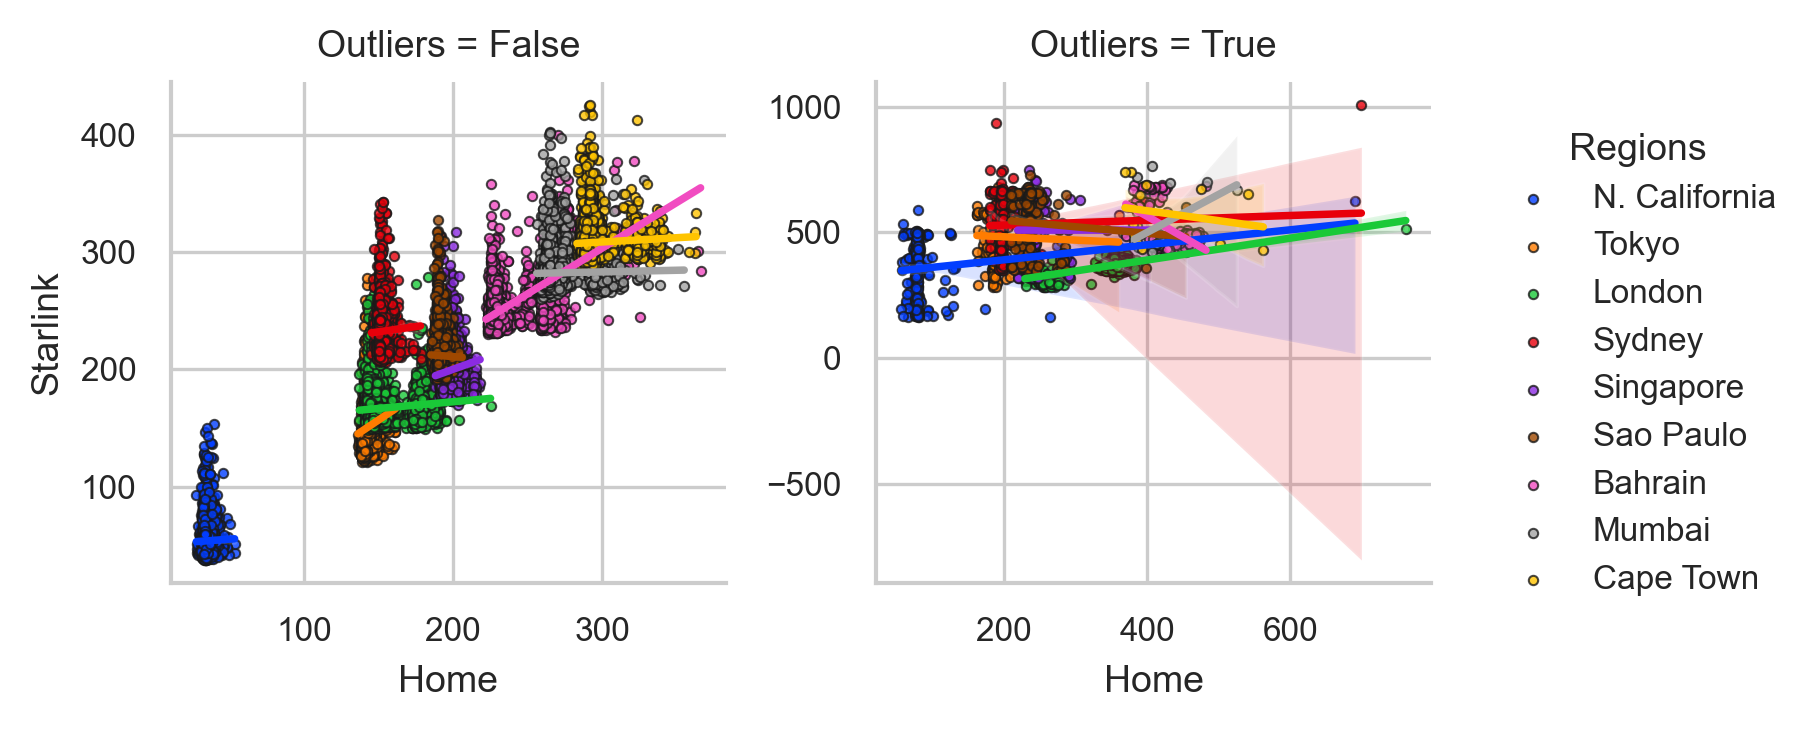

In [65]:
#df_type = df_processed.pivot_table(index=[N_OUTLIERS, N_REGIONS,N_TIMESTAMP], columns=N_TYPE, values=N_LATENCY).reset_index()
df_type = df_sample
#df_type = df_type.dropna(subset=[N_HOME, N_STARLINK])
g_scatter = sns.lmplot(data=df_type,
                       col=N_OUTLIERS,
                       x=N_HOME, y=N_STARLINK,
                        hue=N_REGIONS, hue_order=REGION_ORDER,
                        palette='bright',
                        facet_kws={'sharex': False, 'sharey': False},
                        scatter_kws={'s': 5, 'linewidth': 0.5, 'edgecolor': 'k'},
                       #markers='x',
                       height=2.5)
#g_scatter = sns.displot(data=df_type[df_type[N_OUTLIERS] == False], x=N_HOME, y=N_STARLINK,
#                        binwidth=10, 
#                        hue=N_REGIONS, facet_kws={'sharex': False, 'sharey': False},
#                       height=3, palette='colorblind')

axes = g_scatter.axes.flatten()
#for ax in axes:
#    x0, x1 = ax.get_xlim()
#    y0, y1 = ax.get_ylim()
#    lims = [max(x0, y0), min(x1, y1)]
#    ax.plot(lims, lims, '-r')
#axes[1].set(yscale='log', xscale='log')
#g_scatter.set_titles(col_template="{col_name}")
g_scatter.tight_layout()

In [171]:
g_scatter.savefig(f'{out_path}/regression.pdf', bbox_inches='tight')

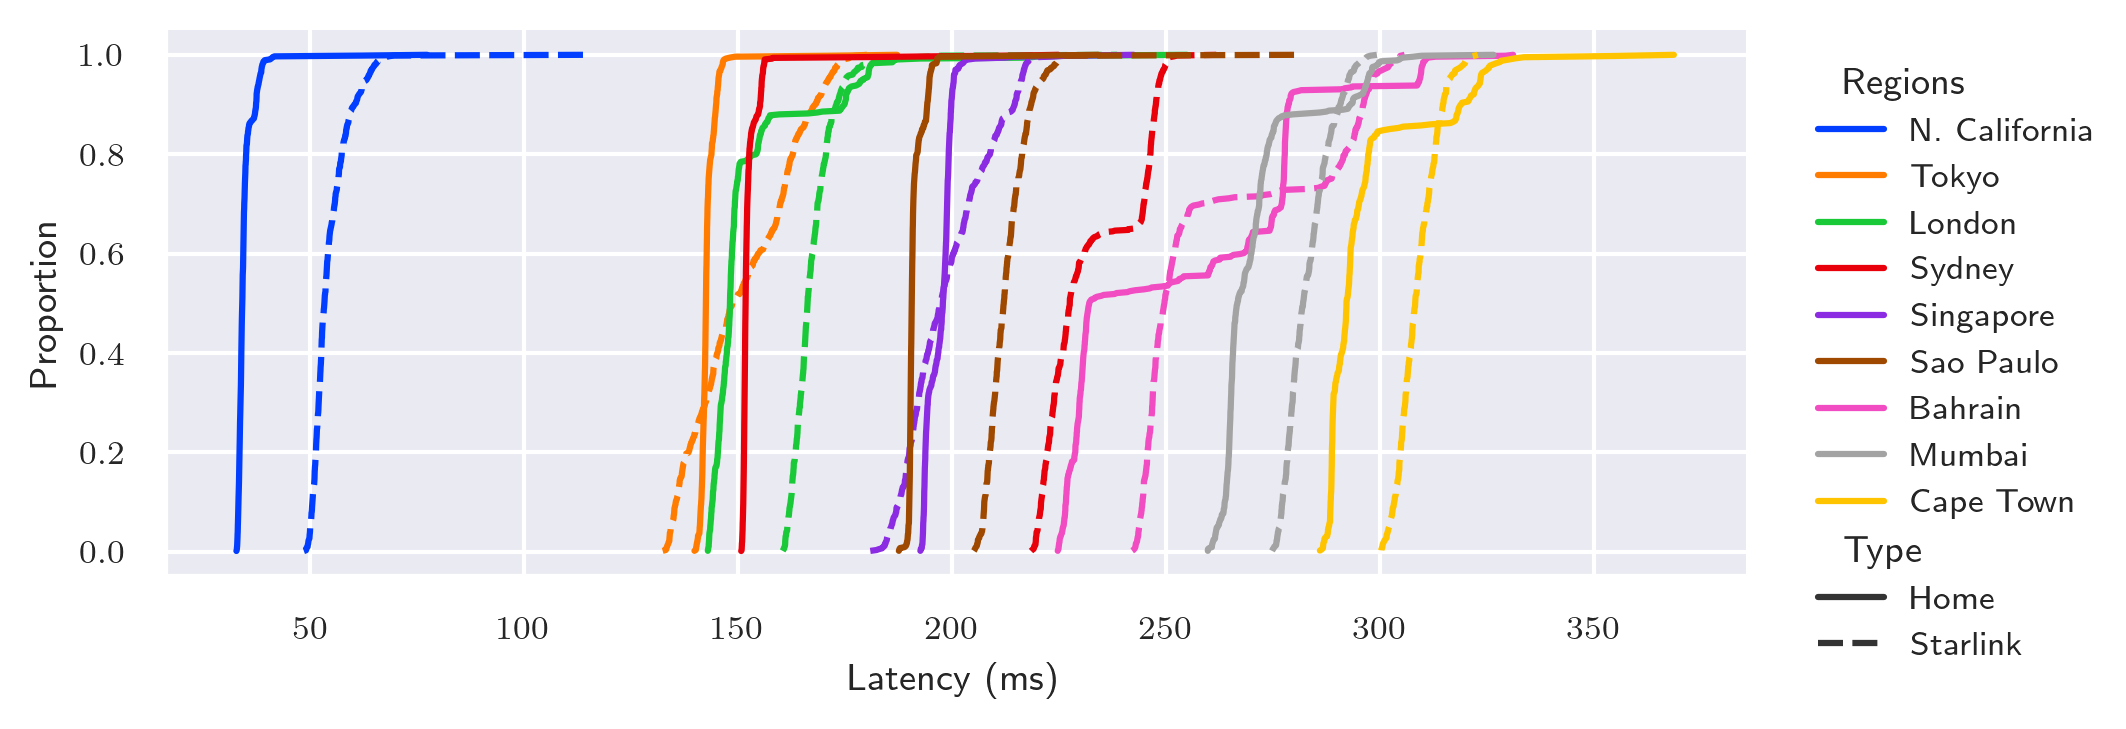

In [125]:
#fig, ax =df_sampleubplots(figsize=(3.5,2))
#fig, ax = plt.subplots(figsize=(7.16,2.5))
#fig_cdf, ax_cdf = plt.subplots(figsize=(7.16,2.5))

#g = sns.ecdfplot(data=df_unstacked, x='latency', hue='Type Region', ax=ax)
g_cdf = sns.relplot(data=df_cdf, x='x', y='y', hue=N_REGIONS, style=N_TYPE,
                hue_order=REGION_ORDER, kind='line', palette='bright',
                height=2.5, aspect=2.424)
#g.set(xscale='log')
#g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g_cdf.set(xlabel='Latency (ms)', ylabel='Proportion')
g_cdf.tight_layout()

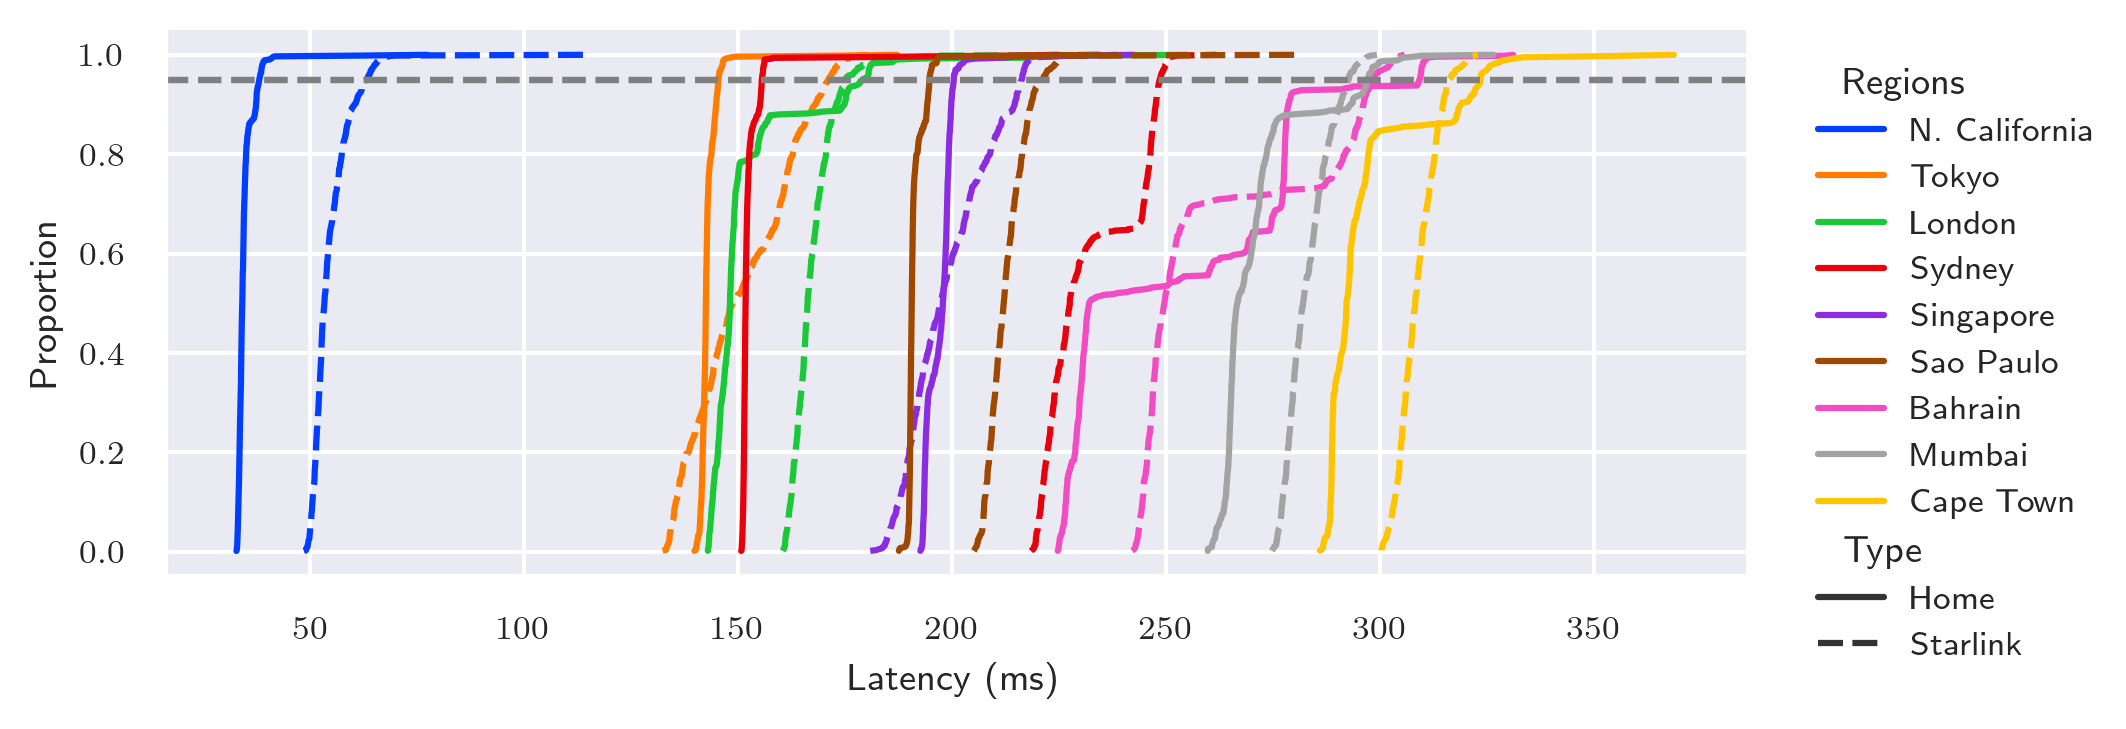

In [127]:
g_cdf.refline(y=0.95)
g_cdf.tight_layout()

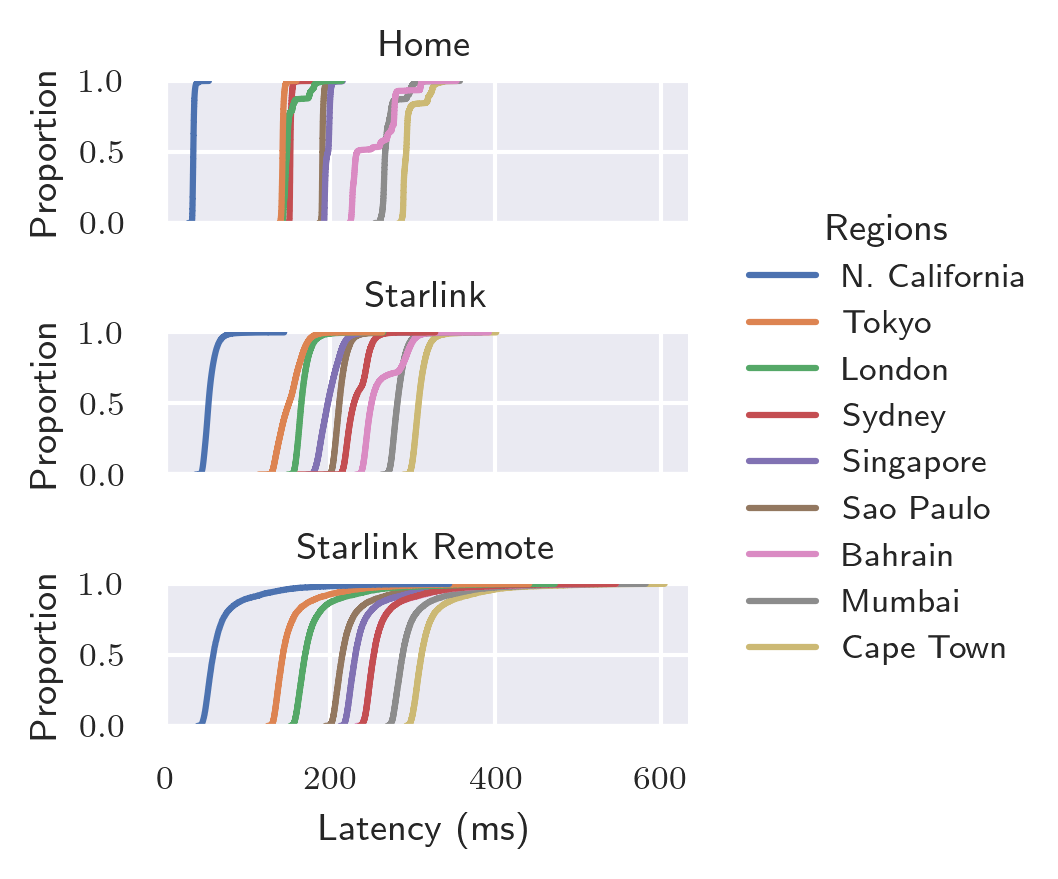

In [24]:
#_, ax_hist = plt.subplots(figsize=(7.16,4), dpi=300)

g_hist = sns.displot(
    data=df_processed[df_processed[N_OUTLIERS] == False], 
    x=N_LATENCY, 
    row=N_TYPE, 
    hue=N_REGIONS, hue_order=common.REGION_ORDER,
    #hue=N_TYPE, 
    kind='ecdf', height=1, aspect=2.5)
g_hist.set_titles(row_template="{row_name}")
g_hist.tight_layout()


In [ ]:
#g_hist.refline(y=0.9)
g_hist.refline(y=0.95)
#g_hist.refline(y=0.99)
g_hist.set_titles(col_template="{col_name}")
g_hist.tight_layout()

In [26]:
g_hist.savefig(f'{filename}_koeye_ping_cdf.pdf', bbox_inches='tight')

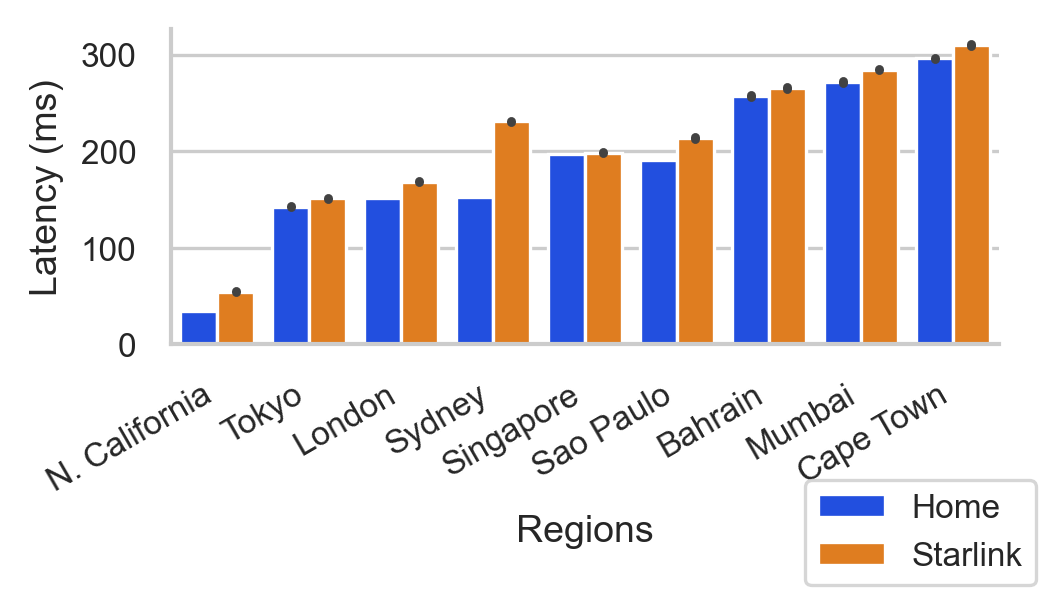

In [16]:
#temp = df_regs.loc['2022-06-03':]

#df_averaged = df.groupby([N_TYPE, N_REGIONS]).std().reset_index()

#styler = df_averaged.style
#styler.format(precision=2)
#styler.to_latex(os.path.join(OUTPUT_FOLDER, '2022-06-05_end_avg_bandwidth.tex'))

df_samp = df_combined.groupby([N_REGIONS]).sample(10000)
g_avg = sns.catplot(data=df_samp,
                    sharey=False,
                    x=N_REGIONS, y=N_LATENCY, hue=N_TYPE,
                    hue_order=[N_HOME, N_STARLINK],
                    order=REGION_ORDER,
                    legend=False,
                    kind='bar', 
                    #ci='sd',
                    height=2, aspect=1.75)

g_avg.figure.autofmt_xdate()
g_avg.figure.legend(loc='lower right')
g_avg.set_titles(row_template="{row_name}")
g_avg.tight_layout()

#df_averaged

In [23]:
g_avg.savefig(f'{OUT_PATH}/2022-06-17_end_all_ping_avg.pdf', bbox_inches='tight')

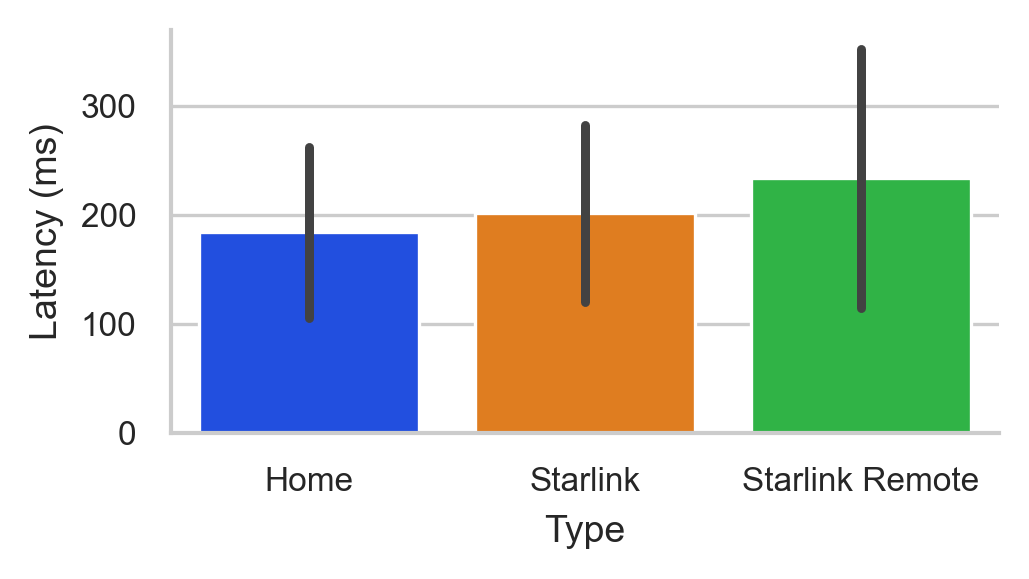

In [42]:
#temp = df_regs.loc['2022-06-03':]

#df_averaged = df.groupby([N_TYPE, N_REGIONS]).std().reset_index()

#styler = df_averaged.style
#styler.format(precision=2)
#styler.to_latex(os.path.join(OUTPUT_FOLDER, '2022-06-05_end_avg_bandwidth.tex'))
g_remote_avg = sns.catplot(data=df_combined,
                    sharey=False,
                    x=N_TYPE, y=N_LATENCY,
                    order=[N_HOME, N_STARLINK, N_STARLINK_REMOTE],
                    legend_out=False,
                    kind='bar', ci='sd',
                    height=2, aspect=1.75)

#g_avg.figure.autofmt_xdate()
g_remote_avg.set_titles(row_template="{row_name}")
g_remote_avg.tight_layout()

#df_averaged

In [25]:
#df_outliers[N_TYPE] = N_STARLINK_REMOTE
#df_outliers[N_TYPE] = df_outliers[N_TYPE].map({'Starlink Koeye': N_STARLINK_REMOTE})

In [26]:
g_remote_avg.savefig(f'{OUT_PATH}/2022-06-21_remote_ping_avg.pdf', bbox_inches='tight')

In [28]:
nt_perc = df_combined.groupby([N_TYPE, N_REGIONS]).quantile(.90)
nf_perc = df_combined.groupby([N_TYPE, N_REGIONS]).quantile(.95)
nn_perc = df_combined.groupby([N_TYPE, N_REGIONS]).quantile(.99)

In [30]:
def diff_table(percentile):
    df_perc = percentile.reset_index().pivot(index=N_REGIONS, columns=N_TYPE, values=N_LATENCY)
    df_perc['diff'] = df_perc[N_STARLINK_REMOTE] - df_perc[N_STARLINK]
    return df_perc.reset_index().pivot_table(columns=N_REGIONS, values='diff')
    
df_perc = diff_table(nt_perc)
df_perc = pd.concat([df_perc, diff_table(nf_perc)])
df_perc = pd.concat([df_perc, diff_table(nn_perc)])
df_perc['Percentile'] = ['90%', '95%', '99%']
df_perc = df_perc.set_index('Percentile')
df_perc

Regions,Bahrain,Cape Town,London,Mumbai,N. California,Sao Paulo,Singapore,Sydney,Tokyo
Percentile,,,,,,,,,
90%,-4.00,28.0,31.0,32.0,33.5,30.0,57.0,45.0,12.0
95%,50.00,83.0,83.0,85.0,84.1,80.0,113.0,98.0,65.0
99%,465.51,492.0,499.0,493.0,496.0,495.0,532.0,517.0,486.0


In [83]:
df_type_avg = df_outliers[df_outliers[N_OUTLIERS] == False].groupby([N_TYPE]).mean()
df_type_avg

,Latency (ms),Outliers
Type,,
Home,183.604080,0.0
Starlink,200.301787,0.0


In [110]:
df_star = df_outliers[df_outliers[N_TYPE] == N_STARLINK]
df_corr = df_star.pivot_table(index=N_TIMESTAMP, columns=N_REGIONS, values=N_LATENCY)
df_corr

In [112]:
df_corr = df_corr.corr()
df_corr

Regions,Bahrain,Cape Town,London,Mumbai,N. California,Sao Paulo,Singapore,Sydney,Tokyo
Regions,,,,,,,,,
Bahrain,1.000000,0.531023,0.435916,0.523741,0.368044,0.512611,0.474942,0.352300,0.510409
Cape Town,0.531023,1.000000,0.530960,0.615328,0.538009,0.629372,0.617139,0.696385,0.526976
London,0.435916,0.530960,1.000000,0.533721,0.513696,0.515329,0.561255,0.494996,0.577317
Mumbai,0.523741,0.615328,0.533721,1.000000,0.493145,0.567466,0.569023,0.640166,0.498123
N. California,0.368044,0.538009,0.513696,0.493145,1.000000,0.483147,0.457279,0.390160,0.540791
Sao Paulo,0.512611,0.629372,0.515329,0.567466,0.483147,1.000000,0.492273,0.500691,0.555297
Singapore,0.474942,0.617139,0.561255,0.569023,0.457279,0.492273,1.000000,0.600782,0.609283
Sydney,0.352300,0.696385,0.494996,0.640166,0.390160,0.500691,0.600782,1.000000,0.538216
Tokyo,0.510409,0.526976,0.577317,0.498123,0.540791,0.555297,0.609283,0.538216,1.000000


In [82]:
file_path = os.path.join('output/Ping/', 'Percentiles.tex')
styler = df_perc.style
styler.format(precision=1)
styler.to_latex(file_path)

In [139]:
g_time.savefig(f'{filename}.pdf', bbox_inches='tight')
g_cdf.savefig(f'{filename}_cdf.pdf', bbox_inches='tight')
#fig.savefig(f'{filename}.pgf', bbox_inches='tight')